In [36]:
%matplotlib inline
import matplotlib.pyplot as plt

In [1]:
import os
os.chdir('../ddCRP/')

In [3]:
import numpy as np

import synthetic
import Priors

In [9]:
# dimensionality of data
d = 5

# sample synthetic features for each label
# If you want to sample synthetic data from a different
# Normal-Inverse-Chi-Squared distribution,
# change kappa, mu, nu, and sigma
synth = synthetic.SampleSynthetic(kind='ell', d=d, mu0=mu, kappa0=kappa, nu0=nu, sigma0=sigma)
synth.fit()

In [24]:
import sampling
import statistics
import subgraphs

import numpy as np
from scipy import spatial
from scipy import cluster

from scipy import sparse

import time

In [25]:
def Ward(D, adj_list, n_clusters):

    """
    Method to apply Ward Clustering to feature data.

    Parameters:
    - - - - -
    D : array
        input feature matrix
    adj_list : dictionary
                adjacency list

    Returns:
    - - - -
    c : array
        cluster assignment of each sample
    """

    D_norm = statistics.Normalize(D)
    similarity = np.corrcoef(D_norm)

    linkage = ClusterTree(similarity, adj_list)
    z = Cluster(linkage, n=n_clusters)
    c = subgraphs.ClusterSpanningTrees(adj_list, z).fit()

    return c


def Cluster(Z, n):
    """
    Wrapper function to compute parcellation from linkage matrix.

    Parameters:
    - - - - -
    Z : array
        linkage matrix
    n : int
        number of components to generate
    """

    z = cluster.hierarchy.fcluster(Z, t=n, criterion='maxclust')
    return z


def ClusterTree(D, adj_list):

    """
    Compute Ward clustering linkage matrix for given similarity matrix
    adjacency structure.

    Parameters:
    - - - - -
    D : array
        similarity matrix
    adj_list : dictionary
                adjacency list

    Returns:
    - - - -
        Z : array
            linkage matrix
    """

    # Compute squared euclidean distance Y between rows
    Qx = np.tile(np.linalg.norm(D, axis=1)**2, (D.shape[0], 1))
    Y = Qx + Qx.transpose()-2*np.dot(D, D.transpose())
    Y = spatial.distance.squareform(Y, checks=False)
    Y[Y < 0] = 0  # Correct for numerical errors in very similar rows

    # Construct adjacency matrix
    N = len(adj_list)
    A = np.zeros([N, N], dtype=bool)
    for i in range(N):
        A[i, adj_list[i]] = True
    connected = spatial.distance.squareform(A).astype(bool)

    # Initialize all data structures
    valid_clusts = np.ones(N, dtype=bool)   # which clusters still remain
    col_limits = np.cumsum(np.concatenate((np.array([N-2]),
                                           np.arange(N-2, 0, -1))))

    # During updating clusters, cluster index is constantly changing, R is
    # a index vector mapping the original index to the current (row, column)
    # index in Y.  C denotes how many points are contained in each cluster.
    m = int(np.ceil(np.sqrt(2*Y.shape[0])))
    C = np.zeros(2*m-1)
    C[0:m] = 1
    R = np.arange(m)
    all_inds = np.arange(Y.shape[0])

    # pairs of adjacent clusters that can be merged
    conn_inds = all_inds[connected]
    Z = np.zeros([m-1, 4])

    for s in range(m-1):
        if conn_inds.size == 0:
            # The graph was disconnected (e.g. two hemispheres)
            # Just add all connections to finish up cluster tree
            connected = np.zeros(len(connected))
            conn_inds = []
            valid_clust_inds = np.flatnonzero(valid_clusts)

            for i in valid_clust_inds:
                U = valid_clusts
                U[i] = 0
                new_conns = PdistInds(i, N, U)
                connected[new_conns] = True
                conn_inds = np.concatenate((conn_inds, new_conns))

            conn_inds = np.unique(conn_inds)

        # Find closest pair of clusters
        v = np.amin(Y[conn_inds])
        k = conn_inds[np.argmin(Y[conn_inds])]

        j = np.where(k <= col_limits)[0][0]
        i = N - (col_limits[j] - k) - 1

        # Add row to output linkage
        Z[s, 0:3] = np.array([R[i], R[j], v])

        # Update Y with this new cluster i containing old clusters i and j
        U = valid_clusts
        U[np.array([i, j])] = 0
        oldI = PdistInds(i, N, U)
        oldJ = PdistInds(j, N, U)
        Y[oldI] = ((
            C[R[U]]+C[R[i]])*Y[oldI] +
            (C[R[U]]+C[R[j]])*Y[oldJ] -
            C[R[U]]*v)/(C[R[i]]+C[R[j]] + C[R[U]])

        # Add j's connections to new cluster i
        new_conns = connected[oldJ] & ~connected[oldI]
        connected[oldI] = connected[oldI] | new_conns
        conn_inds = np.sort(np.concatenate((conn_inds, oldI[new_conns])))

        # Remove all of j's connections from conn_inds and connected
        U[i] = 1
        J = PdistInds(j, N, U)
        conn_inds = conn_inds[np.in1d(conn_inds, J, assume_unique=True,
                                      invert=True)]
        connected[J] = np.zeros(len(J))

        valid_clusts[j] = 0
        # update m, N, R
        C[m+s] = C[R[i]] + C[R[j]]
        Z[s, 3] = C[m+s]
        R[i] = m+s

    Z[:, 2] = np.sqrt(Z[:, 2])
    return Z


def correlation(features):

    """
    Compute sample by sample correlation matrix.

    Parameters:
    - - - - -
    features : array
                sample features

    Returns:
    - - - -
    s : array
        correlation matrix of features
    """

    mu = features.mean(0)
    stdev = features.std(0)
    zs = (stdev != 0).squeeze()

    normed = features[:, zs] - mu[zs][None, :] / stdev[zs][None, :]
    s = np.corrcoef(normed)

    return s


# Compute positions in distance vector (for NxN matrix) for a given row.
# Results are masked by the valid_flags boolean vector
def PdistInds(row, N, valid_flags):
    if row > 0:
        inds1 = np.concatenate((
            [row-1],
            (row-1) + np.cumsum(np.arange(N-2, N-row-1, -1))))
        oldI = np.concatenate((
            inds1,
            [-1],
            np.arange(inds1[-1]+N-row, inds1[-1]+2*N-2*row-1)))
    else:
        oldI = np.arange(N)-1

    oldI = oldI[valid_flags]
    return oldI


In [29]:
class ddCRP(object):
    """
    Class to implement the distance-dependent Chinese Restaurant Process.

    Parameters:
    - - - - -
    alpha: float
        concentration parameter of CRP prior
    model: PriorBase
        type of prior model to use for feature data
    mcmc_passes: int
        number of MCMC passes to apply to data
    stats_interval: int
        number of passes to run before recording statistics
    verbose: bool
        print statistics every stats_interval

    Notes:
    - - - -

    The '''model''' argument assumes that whatever object is provided is a
    subclass of the PriorBase.Prior abstract method.  The model must implement
    the followng three methods:

        - model.sufficient_statistics
        - model.posterior_parameters
        - model.log_likelihood

    Any model that implements these methods will be accepted.  Currently, the
    only two models that are implemented are the Normal-Inverse-Chi-Squared
    and Normal-Inverse-Wishart models.  The NIX model treats each feature as
    independent from the others, while the NIW model does not make this
    assumption.
    """

    def __init__(
        self, alpha, model, mcmc_passes=100, stats_interval=500, ward=False,
            n_clusters=7, verbose=True):

        """
        Initialize ddCRP object.
        """

        self.alpha = np.float(alpha)
        self.model = model
        self.mcmc_passes = np.int(mcmc_passes)
        self.stats_interval = np.int(stats_interval)
        self.ward = ward
        self.n_clusters = n_clusters
        self.verbose = verbose

    def fit(self, features, adj_list, init_c=None, gt_z=None, edge_prior=None):

        """
        Main function to fit the distance-dependent Chinese Restaurant Process.
        Parameters:
        - - - - -
        features : array
                data array of features for each sample
        adj_list : dictionary
                adjacency list of samples
        init_c : array
                initialized cortical map, default = []
        gt_z : array
                ground truth map for computing normalized mutual information
        edge_prior : dictionary
                nested dictionary, probability of neighboring vertices beloning
                to same parcels
        """

        # initialize Gibbs sampling object
        gibbs = sampling.Gibbs()
        nvox = len(adj_list)

        # normalize each feature to have zero mean, unit variance
        features = statistics.Normalize(features)

        stats = {
            'times': [], 'lp': [], 'max_lp': [],
            'K': [], 'z': np.empty((0, nvox)),
            'c': np.empty((0, nvox)), 'NMI': [],
            'deltaC': [], 'boundC': []}

        # initialize parent vector, if not provided
        # if ward parameter is set to True, will
        if self.ward:

            init_c = ward_clustering.Ward(features, adj_list, self.n_clusters)

        # compute initial linkage matrix
        [c, G] = self._sparse_linkage(adj_list, nvox, init_c)

        # compute initial parcel count and parcel assignments
        [K, z, parcels] = subgraphs.ConnectedComponents(G)
        self.init_z = z

        # compute log-likelihood of initial cortical map
        curr_lp = self._fullProbabilityDDCRP(parcels, features)

        max_lp = -1.*np.inf
        map_z, boundC, deltaC = [], [], []
        t0 = time.time()
        steps = 0

        order = np.arange(nvox)

        # perform mcmc_passes of over all samples
        for mcmc_pass in np.arange(self.mcmc_passes):

            # shuffle sample order for each MCMC pass
            np.random.shuffle(order)

            for i in order:

                # if current map log-probability greater than current max
                # set current map to best map
                if curr_lp > max_lp:
                    max_lp = curr_lp
                    map_z = z

                if steps % self.stats_interval == 0:
                    stats = statistics.UpdateStats(
                        stats, t0, curr_lp, max_lp,
                        K, list(z), list(c), steps,
                        gt_z, map_z, deltaC, boundC,
                        self.verbose)

                # remove current link to parent
                G[i, c[i]] = 0

                # if link was self-link
                if c[i] == i:
                    # Removing self-loop, parcellation won't change
                    rem_delta_lp = -np.log(self.alpha)
                    z_rem = z
                    parcels_rem = parcels
                else:
                    # otherwise compute new connected components
                    K_rem, z_rem, parcels_rem = subgraphs.ConnectedComponents(
                        G)

                    # if number of components changed
                    if K_rem != K:
                        # We split a cluster, compute change in likelihood
                        rem_delta_lp = -self._LogProbDifference(
                            parcels_rem, z_rem[i], z_rem[c[i]], features)

                    else:
                        rem_delta_lp = 0

                # get neighbors of sample i
                adj_list_i = adj_list[i]

                # initialize empty log-prob vector
                lp = np.zeros((len(adj_list_i)+1,))
                lp[-1] = np.log(self.alpha)

                for j, n in enumerate(adj_list_i):
                    # just undoing split
                    if z_rem[n] == z_rem[c[i]]:
                        lp[j] = -rem_delta_lp - (c[i] == i)*np.log(self.alpha)

                    # (possibly) new merge
                    elif z_rem[n] != z_rem[i]:
                        lp[j] = self._LogProbDifference(
                            parcels_rem, z_rem[i], z_rem[n], features)

                # sample new neighbor according to Gibbs
                new_neighbor = gibbs.sample(lp)
                if new_neighbor < len(adj_list_i):
                    c[i] = adj_list_i[new_neighbor]
                else:
                    c[i] = i

                # update current full log-likelihood with new parcels
                curr_lp = curr_lp + rem_delta_lp + lp[new_neighbor]
                # add new edge to parent graph
                G[i, c[i]] = 1
                # compute new connected components
                [K_new, z_new, parcels_new] = subgraphs.ConnectedComponents(G)

                deltaC = statistics.delta_C(parcels, parcels_new)
                boundC = statistics.boundaries(z_new, adj_list)
                K, z, parcels = K_new, z_new, parcels_new
                steps += 1

        # update diagnostic statistics
        stats = statistics.UpdateStats(
            stats, t0, curr_lp, max_lp, K,
            list(z), list(c), steps, gt_z,
            map_z, deltaC, boundC, self.verbose)

        # for visualization purposes
        map_z[np.where(map_z == 0)[0]] = map_z.max() + 1

        self.map_z_ = map_z
        self.stats_ = stats

    def _fullProbabilityDDCRP(self, parcels, features):
        """
        Compute the full log-likelihood of the clustering.
        Parameters:
        - - - - -
        parcels : dictionary
                mapping between cluster ID and sample indices
        features : array
                data samples
        Returns:
        - - - -
        lp : float
                marginal log-likelihood of a whole parcelation
        """

        model = self.model

        feats = [features[idx, :] for idx in parcels.values()]

        suff_stats = map(model.sufficient_statistics, feats)
        posteriors = map(model.posterior_parameters, suff_stats)
        cluster_prob = map(model.log_likelihood, posteriors, suff_stats)

        lp = np.sum(list(cluster_prob))

        return lp

    def _LogProbDifference(self, parcel_split, split_l1, split_l2, features):
        """
        Compute change in log-likelihood when considering a merge.

        Parameters:
        - - - - -
        parcel_split : dictionary
                mapping of cluster ID to sample indices
        split_l1 , split_l2 : int
                label values of components to merge
        features : array
                data samples
        Returns:
        - - - -
        ld : float
                log of likelihood ratio between merging and splitting
                two clusters
        """

        model = self.model

        merged_indices = np.concatenate([parcel_split[split_l1],
                                        parcel_split[split_l2]])

        # compute sufficient statistics, marginalized parameters
        # and log-likelihood of merged parcels
        merge_stats = model.sufficient_statistics(features[merged_indices, :])
        merge_phyp = model.posterior_parameters(merge_stats)
        merge_ll = model.log_likelihood(merge_phyp, merge_stats)

        # compute likelihood of split parcels
        split_ll = self._LogProbSplit(
            parcel_split, split_l1, split_l2, features)

        ld = merge_ll - split_ll

        return ld

    def _LogProbSplit(self, parcel_split, split_l1, split_l2, features):
        """
        Compute change in log-likelihood when consiering a split.
        Parameters:
        - - - - -
        parcel_split : dictionary
                mapping of cluster ID to sample indices
        split_l1 , split_l2 : int
                label values of components to merge
        features : array
                data samples
        Returns:
        - - - -
        split_ll : float
                log-likelihood of two split clusters
        """

        model = self.model

        idx1 = parcel_split[split_l1]
        idx2 = parcel_split[split_l2]

        suff1 = model.sufficient_statistics(features[idx1, :])
        suff2 = model.sufficient_statistics(features[idx2, :])

        phyp1 = model.posterior_parameters(suff1)
        phyp2 = model.posterior_parameters(suff2)

        lp_1 = model.log_likelihood(phyp1, suff1)
        lp_2 = model.log_likelihood(phyp2, suff2)

        split_ll = lp_1 + lp_2

        return split_ll

    def _sparse_linkage(self, adj_list, nvox, init_c=None):

        """
        Compute source-to-target linkages and sparse neighborhood matrix.
        Parameters:
        - - - - -
        adj_list: dictionary
            adjacency list of samples
        nvox: int
            number of samples
        init_c: array
            initial source-to-taret linkages
        """

        if not np.any(init_c):
            c = np.zeros((nvox,))
            for i in np.arange(nvox):
                neighbors = adj_list[i] + [i]
                c[i] = neighbors[np.random.randint(low=0, high=len(neighbors))]
        else:
            c = init_c

        c = c.astype(np.int32)

        # initialize sparse linkage matrix
        G = sparse.csc_matrix(
            (np.ones((nvox, )), (np.arange(nvox), c)), shape=(nvox, nvox))

        G = G.tolil()

        return [c, G]


In [86]:
alpha=10
mu = 0
kappa = 0.0001
nu = 9
sigma = 1

nix = Priors.NIX2(mu0=mu, kappa0=kappa, nu0=nu, sigma0=sigma)
niw = Priors.NIW(mu0=np.zeros((1,5)),kappa0=0.1,nu0=10,lambda0=np.random.rand(5,5)+np.eye(5))

In [87]:
crp = ddCRP(alpha=alpha,model=niw,n_clusters=10,mcmc_passes=20,stats_interval=200)

In [88]:
crp.fit(adj_list=synth.adj_list_,features=synth.features_,gt_z=synth.z_)

Step: 0 Time: -1535168041.694146 LP: -701.9154520291966 K: 101 MaxLP: -701.9154520291966
Step: 200 Time: -1535168040.5176947 LP: 260.3094587430888 K: 46 MaxLP: 260.3094587430888
Step: 400 Time: -1535168039.4437978 LP: 940.5301663958396 K: 20 MaxLP: 945.1353365818276
Step: 600 Time: -1535168038.3980708 LP: 1100.3659589725867 K: 15 MaxLP: 1100.3659589725867
Step: 800 Time: -1535168037.3566988 LP: 1328.1503680210603 K: 11 MaxLP: 1328.1503680210606
Step: 1000 Time: -1535168036.2842588 LP: 1471.0298529663678 K: 8 MaxLP: 1472.7135808325033
Step: 1200 Time: -1535168035.244351 LP: 1553.592769574003 K: 7 MaxLP: 1553.5927695740031
Step: 1400 Time: -1535168034.1778698 LP: 1562.0681095739524 K: 7 MaxLP: 1562.0681095739524
Step: 1600 Time: -1535168033.1243699 LP: 1563.88357263247 K: 7 MaxLP: 1566.1861577254645
Step: 1800 Time: -1535168032.044896 LP: 1589.5233834906228 K: 7 MaxLP: 1589.5233834906228
Step: 2000 Time: -1535168030.9654088 LP: 1606.8885909624641 K: 7 MaxLP: 1606.8885909624646
Step: 2200

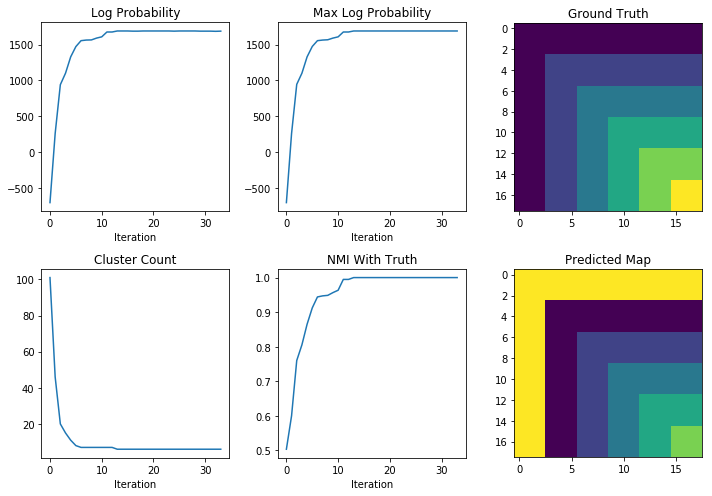

In [89]:
fig,[[ax1,ax2,ax5],[ax3,ax4,ax6]] = plt.subplots(2,3,figsize=(10,7))

ax1.plot(crp.stats_['lp'])
ax1.set_title('Log Probability')
ax1.set_xlabel('Iteration')

ax2.plot(crp.stats_['max_lp'])
ax2.set_title('Max Log Probability')
ax2.set_xlabel('Iteration')

ax3.plot(crp.stats_['K'])
ax3.set_title('Cluster Count')
ax3.set_xlabel('Iteration')

ax4.plot(crp.stats_['NMI'])
ax4.set_title('NMI With Truth')
ax4.set_xlabel('Iteration')

ax5.imshow(synth.z_.reshape(18,18))
ax5.set_title('Ground Truth')

ax6.imshow(crp.map_z_.reshape(18,18))
ax6.set_title('Predicted Map')
plt.tight_layout()